# РК №2

## Коростелев А.М., Вариант № 8, ИУ5-64Б

### Задание. Для заданного набора данных построить модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей использовать методы 1 и 2 (по варианту для Вашей группы). Оценить качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

### Методы ИУ5-64Б - Линейная регрессия и градиентный бустинг

### Набор данных №8:

https://www.kaggle.com/lava18/google-play-store-apps

### 1) Импорт библиотек. Загрузка и первичный анализ данных.

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [32]:
data = pd.read_csv('data/googleplaystore.csv', sep=",")

In [33]:
# Размер датасета
data.shape

(10841, 13)

In [34]:
# Первые 10 строк датасета
data.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [35]:
# Проверка на пропуски
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [36]:
# Удаление строк, содержащих пустые значения
data = data.dropna(axis=0, how='any')
data.shape

(9360, 13)

Мы избавились от пропусков, однако имеем всего лишь один количественный параметр. Необходимо перевести параметры Reviews, Size, Installs и Price в числовой формат.

In [37]:
data.loc[:, 'Reviews']=pd.to_numeric(data.loc[:, 'Reviews'])

In [38]:
data.loc[:, 'Installs'] = data.loc[:, 'Installs'].str.replace(',','')
data.loc[:, 'Installs'] = data.loc[:, 'Installs'].map(lambda x: str(x).rstrip('+'))
data.loc[:, 'Installs'] = pd.to_numeric(data.loc[:, 'Installs'], errors='coerce', downcast='float')

In [39]:
data['Price'].value_counts()

0          8715
$2.99       114
$0.99       106
$4.99        70
$1.99        59
           ... 
$4.59         1
$3.02         1
$1.20         1
$4.60         1
$379.99       1
Name: Price, Length: 73, dtype: int64

In [40]:
data.loc[:, 'Price'] = data.loc[:, 'Price'].map(lambda x: str(x).lstrip('$'))
data.loc[:, 'Price'] = pd.to_numeric(data.loc[:, 'Price'], errors='coerce', downcast='float')

In [41]:
data['Size'].value_counts()

Varies with device    1637
14M                    165
12M                    161
11M                    159
15M                    159
                      ... 
45k                      1
144k                     1
313k                     1
994k                     1
239k                     1
Name: Size, Length: 413, dtype: int64

In [42]:
data.loc[:, 'Size'] = data.loc[:, 'Size'].map(lambda x: str(x).rstrip('M'))
data.loc[:, 'Size'] = data.loc[:, 'Size'].map(lambda x: str(x).rstrip('k'))
data.loc[:, 'Size'] = pd.to_numeric(data.loc[:, 'Size'], errors='coerce', downcast='float')

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [44]:
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data[['Size']])   
imp_num = SimpleImputer(strategy='mean')
data_num_imp = imp_num.fit_transform(data[['Size']])
filled_data = data_num_imp[mask_missing_values_only]
data = data.replace(np.nan, filled_data[0])

Проверяем.

In [45]:
# Тип данных
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size              float32
Installs          float32
Type               object
Price             float32
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [46]:
# Проверка на пропуски
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Проверим количество уникальных значений в параметрах Category, Type, Content Rating и Genres.

In [47]:
print(f"Количество уникальных записей атрибута 'Category' = {data['Category'].nunique()} из {data.shape[0]}")

Количество уникальных записей атрибута 'Category' = 33 из 9360


In [48]:
print(f"Количество уникальных записей атрибута 'Type' = {data['Type'].nunique()} из {data.shape[0]}")

Количество уникальных записей атрибута 'Type' = 2 из 9360


In [49]:
print(f"Количество уникальных записей атрибута 'Content Rating' = {data['Content Rating'].nunique()} из {data.shape[0]}")

Количество уникальных записей атрибута 'Content Rating' = 6 из 9360


In [50]:
print(f"Количество уникальных записей атрибута 'Genres' = {data['Genres'].nunique()} из {data.shape[0]}")

Количество уникальных записей атрибута 'Genres' = 115 из 9360


Т.к. количество уникальных значение атрибута Genres слишком большое, то его учёт усложнит построение модели машинного обучения. Также, название приложения, версии и дата обновления не имеют большой информативности. Т.о. параметры App, Genres, Last Updated, Current Ver и Android Ver можно удалить.

In [51]:
data = data.drop(['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1)

Преобразуем категориальные признаки Category, Type и Content Rating в числовые.

In [52]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [53]:
le = LabelEncoder()
data['Category'] = le.fit_transform(data['Category'])

In [54]:
data['Content Rating'] = le.fit_transform(data['Content Rating'])

In [55]:
data = pd.get_dummies(data, columns = ['Type'])

MinMax масштабировние параметров 

In [56]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [62]:
data['Rating'] = MinMaxScaler().fit_transform(data[['Rating']])
data['Reviews'] = MinMaxScaler().fit_transform(data[['Reviews']])
data['Installs'] = MinMaxScaler().fit_transform(data[['Installs']])
data['Size'] = MinMaxScaler().fit_transform(data[['Size']])
data['Price'] = MinMaxScaler().fit_transform(data[['Price']])
data['Content Rating'] = MinMaxScaler().fit_transform(data[['Price']])

In [63]:
# Тип данных
data.dtypes

Category            int32
Rating            float64
Reviews           float64
Size              float32
Installs          float32
Price             float32
Content Rating    float32
Type_Free           uint8
Type_Paid           uint8
dtype: object

In [64]:
# Проверка на пропуски
data.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Price             0
Content Rating    0
Type_Free         0
Type_Paid         0
dtype: int64

Таким образом мы имеем отмасштабированные данные без пропусков и в числовом формате

In [65]:
# Первые 10 строк датасета
data.head(10)

,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Type_Free,Type_Paid
0,0,0.775,0.000002,0.018127,0.00001,0.0,0.0,1,0
1,0,0.725,0.000012,0.013092,0.00050,0.0,0.0,1,0
2,0,0.925,0.001120,0.007754,0.00500,0.0,0.0,1,0
3,0,0.875,0.002759,0.024169,0.05000,0.0,0.0,1,0
4,0,0.825,0.000012,0.001813,0.00010,0.0,0.0,1,0
5,0,0.850,0.000002,0.004632,0.00005,0.0,0.0,1,0
6,0,0.700,0.000002,0.018127,0.00005,0.0,0.0,1,0
7,0,0.775,0.000471,0.028197,0.00100,0.0,0.0,1,0
8,0,0.850,0.000176,0.032226,0.00100,0.0,0.0,1,0
9,0,0.925,0.000002,0.002115,0.00001,0.0,0.0,1,0


Проведём корреляционный анализ

In [66]:
data.corr()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Type_Free,Type_Paid
Category,1.000000,-0.035154,0.000888,0.008860,0.022778,-0.012920,-0.012920,-0.023258,0.023258
Rating,-0.035154,1.000000,0.068133,-0.018149,0.051337,-0.021919,-0.021919,-0.039592,0.039592
Reviews,0.000888,0.068133,1.000000,0.019671,0.641605,-0.009824,-0.009824,0.043244,-0.043244
Size,0.008860,-0.018149,0.019671,1.000000,0.008248,0.018469,0.018469,-0.046003,0.046003
Installs,0.022778,0.051337,0.641605,0.008248,1.000000,-0.011895,-0.011895,0.053049,-0.053049
Price,-0.012920,-0.021919,-0.009824,0.018469,-0.011895,1.000000,1.000000,-0.223344,0.223344
Content Rating,-0.012920,-0.021919,-0.009824,0.018469,-0.011895,1.000000,1.000000,-0.223344,0.223344
Type_Free,-0.023258,-0.039592,0.043244,-0.046003,0.053049,-0.223344,-0.223344,1.000000,-1.000000
Type_Paid,0.023258,0.039592,-0.043244,0.046003,-0.053049,0.223344,0.223344,-1.000000,1.000000


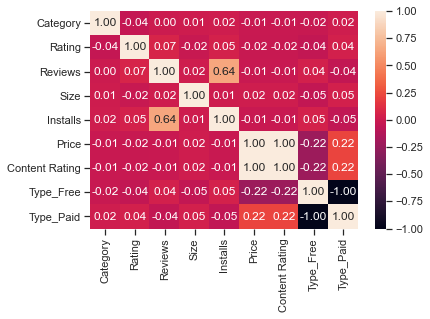

In [67]:
sns.heatmap(data.corr(), annot=True, fmt=".2f");

### 2) Разделение выборки на обучающую и тестовую.

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
data_X = data.drop(columns='Installs')
data_Y = data['Installs']
X_train, X_test, Y_train, Y_test = train_test_split(data_X,  data_Y, test_size=0.25, random_state = 0)

In [71]:
# Проверим правильность разделения выборки на тестовую и обучающую. Посмотрим на размеры матриц.
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7020, 8)
(2340, 8)
(7020,)
(2340,)


In [72]:
print('Входные параметры обучающей выборки:\n\n',X_train.head(), \
      '\n\nВходные параметры тестовой выборки:\n\n', X_test.head(), \
      '\n\nВыходные параметры обучающей выборки:\n\n', Y_train.head(), \
      '\n\nВыходные параметры тестовой выборки:\n\n', Y_test.head())

Входные параметры обучающей выборки:

       Category  Rating   Reviews      Size  Price  Content Rating  Type_Free  \
1482        16   0.875  0.001322  0.036563    0.0             0.0          1   
7572        24   0.900  0.010839  0.003223    0.0             0.0          1   
4337        11   0.875  0.000054  0.012085    0.0             0.0          1   
5849        18   0.775  0.000038  0.036563    0.0             0.0          1   
9513        11   0.500  0.000000  0.004834    0.0             0.0          1   

      Type_Paid  
1482          0  
7572          0  
4337          0  
5849          0  
9513          0   

Входные параметры тестовой выборки:

       Category  Rating       Reviews      Size  Price  Content Rating  \
1794        14   0.850  4.752238e-02  0.035247    0.0             0.0   
5691        14   0.700  2.035126e-03  0.084592    0.0             0.0   
4741        24   0.800  4.439707e-06  0.000504    0.0             0.0   
5380        14   0.875  1.312081e-04  0.

### 3) Обучение и тестирование моделей

#### Модель "Линейная регрессия"

In [77]:
from sklearn.linear_model import LinearRegression

In [79]:
reg = LinearRegression().fit(X_train, Y_train.values.reshape(-1, 1))
reg.coef_, reg.intercept_

(array([[ 3.39348212e-04,  9.02900662e-03,  1.32476456e+00,
         -3.00469995e-03,  1.14220153e-03,  1.14220153e-03,
          4.63489976e-03, -4.63489976e-03]]),
 array([-0.00876123]))

In [81]:
target1 = reg.predict(X_test)
mean_squared_error(Y_test, target1), mean_absolute_error(Y_test, target1)

(0.006536702679128915, 0.018885370366650535)

#### Модель "Градиентный бустинг"

In [75]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 

In [82]:
gr_boost_app = GradientBoostingRegressor(random_state=1)
gr_boost_app.fit(X_train, Y_train)
target2 = gr_boost_app.predict(X_test)
mean_squared_error(Y_test, target2), mean_absolute_error(Y_test, target2)

(0.001931641888629118, 0.009041385437490956)

### 4) Выводы

В РК были использованы метрики MAE и MSE. Они помогают определить точность регрессии - среднее отклонение и дисперсию.

Метод градиентного бустинга показал себя гораздо лучше по сравнению с методом линейной регрессии. Это можно попробовать объяснить тем, что в данном датасете присутствуют много сложных зависимостей, а линейная регрессия не проявила себя в полной мере из-за того, что датасет не содержит большого количества линейных зависимостей.